In [1]:
from numpy import genfromtxt
from PIL import Image, ImageDraw, ImageChops
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from skimage.morphology import binary_opening, binary_closing,binary_erosion, rectangle, binary_dilation, disk
from skimage.segmentation import find_boundaries


# From Converted RJPEG To Temperature csv

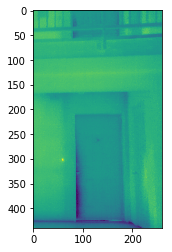

In [2]:
thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/Thermal_preproc/temperature_DJI_0490_door.csv', delimiter=',')
#thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/singapore/Thermal_preproc/IX-x1-00057_0278_0109_THM.csv', delimiter=',')

# thermal_tab = np.rot90(thermal_tab,3)
# exclude the bottom right column because of some noise
# thermal_tab = thermal_tab[0:147,0:485]
plt.figure()
plt.imshow(thermal_tab)

In [3]:
thermal_tab.shape

(440, 261)

In [4]:
np.amax(thermal_tab)

45.6255122839727

In [5]:
np.amin(thermal_tab)

33.735131628942

In [6]:
pixel_values = thermal_tab.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
pixel_values.shape

(114840, 1)

In [7]:
pixel_values_croped = pixel_values.reshape((-1, 1))
pixel_values_croped.shape

(114840, 1)

In [8]:
pixel_values_croped

array([[41.745377],
       [41.745377],
       [41.565193],
       ...,
       [40.73281 ],
       [40.660152],
       [40.56927 ]], dtype=float32)

In [9]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [10]:
# number of clusters (K)
k = 8
_, labels, (centers) = cv2.kmeans(pixel_values_croped, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [11]:
centers

array([[38.12368 ],
       [41.932888],
       [41.10238 ],
       [36.567707],
       [39.278748],
       [35.03951 ],
       [39.933758],
       [40.481453]], dtype=float32)

In [12]:
labels

array([[1],
       [1],
       [1],
       ...,
       [2],
       [7],
       [7]], dtype=int32)

In [13]:
# convert back to 8 bit values
centers = np.int8(centers)

# flatten the labels array
labels = labels.flatten()

In [14]:
centers

array([[38],
       [41],
       [41],
       [36],
       [39],
       [35],
       [39],
       [40]], dtype=int8)

In [15]:
# convert all pixels to the color of the centroids
segmented_image_copped = centers[labels.flatten()]

In [16]:
segmented_image_copped.shape

(114840, 1)

In [17]:
segmented_image_copped.dtype

dtype('int8')

In [19]:
pixel_values.shape

(114840, 1)

In [20]:
segmented_image= segmented_image_copped

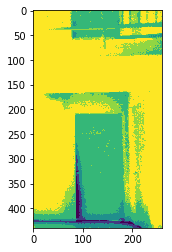

In [21]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(thermal_tab.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

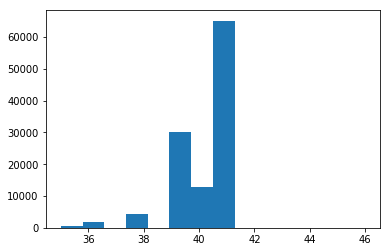

((array([  693.,  1698.,     0.,  4380.,     0., 30012., 12972., 65085.,
             0.,     0.,     0.,     0.,     0.,     0.]),
  array([35.        , 35.78571429, 36.57142857, 37.35714286, 38.14285714,
         38.92857143, 39.71428571, 40.5       , 41.28571429, 42.07142857,
         42.85714286, 43.64285714, 44.42857143, 45.21428571, 46.        ]),
  <a list of 14 Patch objects>),
 None)

In [22]:
from matplotlib import pyplot as plt

# x = np.random.randint(25,100,25)
# y = np.random.randint(175,255,25)
# z = np.hstack((x,y))
# z = z.reshape((50,1))
# z = np.float32(z)
plt.hist(segmented_image_copped,14,[35,46]),plt.show()


In [23]:
segmented_image_f = np.float32(segmented_image)

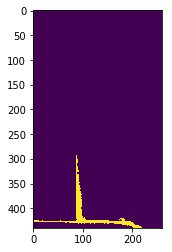

In [24]:
th = cv2.threshold(segmented_image_f,36,255,cv2.THRESH_BINARY)[1]
thresholded = th.astype(np.uint8)
thresholded = np.invert(thresholded)
plt.figure()
plt.imshow(thresholded)

In [26]:
thresholded = binary_dilation(thresholded, rectangle(1,5))

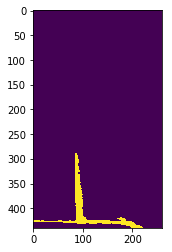

In [27]:
plt.figure()
plt.imshow(thresholded)

In [28]:
# thresholded = binary_erosion(thresholded, rectangle(5,1))
# plt.figure()
# plt.imshow(thresholded)

In [29]:
thresholded_2 = thresholded.astype(np.uint8)
contours, hierarchy = cv2.findContours(thresholded_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### Create RGB images

In [30]:
thermal_im = 255*(thermal_tab - np.min(thermal_tab))/np.ptp(thermal_tab).astype(int)

In [31]:
thermal_im = cv2.cvtColor(thermal_im.astype(np.uint8),cv2.COLOR_GRAY2RGB)

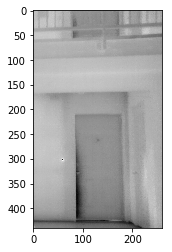

In [32]:
plt.figure()
plt.imshow(thermal_im)

In [33]:
mask = np.zeros(thermal_im.shape, np.uint8)
borders_im = cv2.drawContours(mask, contours, -1, (255,0,0),3)

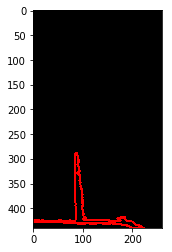

In [34]:
plt.figure()
plt.imshow(borders_im)

#### superimpose images


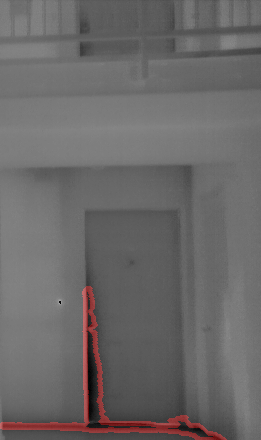

In [35]:
thermal_im_1 = Image.fromarray(thermal_im)
borders_im_1 = Image.fromarray(borders_im)
thermal_im_1 = thermal_im_1.convert("RGBA")
borders_im_1 = borders_im_1.convert("RGBA")
new_img = Image.blend(thermal_im_1, borders_im_1, 0.35)
new_img